In [1]:
import pytest
import deepchem as dc
import tempfile
import pandas as pd
import numpy as np
import os
print(os.getcwd())
from dataset_mpnn import get_dataset, get_class_imbalance_ratio
from deepchem.models.optimizers import ExponentialDecay
from datetime import datetime
from sklearn.metrics import roc_auc_score
from utils.splitter import iterative_train_test_split
import logging
import torch

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/ary2260/miniconda3/envs/odor_pom/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ary2260/miniconda3/envs/odor_pom/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


/home/ary2260/Work/UK Research/odor-model-pipeline/MPNN


In [2]:
torch.manual_seed(1)
# load sample dataset
# dataset, _ = get_dataset(csv_path='assets/GS_LF_sample100.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4984.csv')
dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4983.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4983_L_priority.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4970_50_plus.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4948_75_plus.csv')
n_tasks = len(dataset.tasks)
#%%
# randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
# train_dataset, test_dataset = randomstratifiedsplitter.train_test_split(dataset, frac_train = 0.8, seed = 1)
# train_dataset, test_dataset = iterative_train_test_split(dataset, test_size= 0.2, random_state=None, train_dir=None, test_dir=None)
# train_ratios = get_class_imbalance_ratio(pd.DataFrame(train_dataset.y))
# learning_rate = ExponentialDecay(initial_rate=0.01, decay_rate=0.5, decay_steps=3000, staircase=True)

# %%


number of odor tasks =  138


Failed to featurize datapoint 3408, O. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3413, [Cl-].[K+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3581, [He]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3582, [Zn]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3601, O.O.O.O.O.O.[Cl-].[Cl-].[Co+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3614, [Cl-].[NH4+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3615, [NH4+].[NH4+].[S-2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3715, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 4445, [Ca+2].[OH-].[OH-]. Appending empt

In [3]:
learning_rate = 0.001
# initialize the model
from custom_mpnn import CustomMPNNModel
from featurizer import GraphConvConstants
from custom_mpnn import CustomMPNNModel
model = CustomMPNNModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = [],
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = 5,
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            log_frequency = 32,
                            model_dir = './models')

model.restore('./models/checkpoint1.pt')

In [5]:
pom_embeds = model.predict_embedding(dataset)

In [6]:
pom_embeds.shape

(4972, 256)

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

def pom_frame(model, dataset, epoch):
    pom_embeds = model.predict_embedding(dataset)
    required_desc = list(dataset.tasks)
    type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
    type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
    type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}
    
    # Assuming you have your features in the 'features' array
    pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
    reduced_features = pca.fit_transform(pom_embeds)

    variance_explained = pca.explained_variance_ratio_

    # Variance explained by PC1 and PC2
    variance_pc1 = variance_explained[0]
    variance_pc2 = variance_explained[1]

    print(variance_pc1, variance_pc2)

    y = dataset.y
    # Generate grid points to evaluate the KDE on
    x_grid, y_grid = np.meshgrid(np.linspace(reduced_features[:, 0].min(), reduced_features[:, 0].max(), 500),
                                 np.linspace(reduced_features[:, 1].min(), reduced_features[:, 1].max(), 500))
    grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])

    def get_kde_values(label):
        plot_idx = required_desc.index(label)
        label_indices = np.where(y[:, plot_idx] == 1)[0]
        kde_label = gaussian_kde(reduced_features[label_indices].T)
        kde_values_label = kde_label(grid_points)
        kde_values_label = kde_values_label.reshape(x_grid.shape)
        return kde_values_label
    
    def plot_contours(type_dictionary, bbox_to_anchor):
        main_label = list(type_dictionary.keys())[0]
        plt.contourf(x_grid, y_grid, get_kde_values(main_label), levels=1, colors=['#00000000',type_dictionary[main_label],type_dictionary[main_label]])
        legend_elements = []
        for label, color in type_dictionary['subs'].items():
            plt.contour(x_grid, y_grid, get_kde_values(label), levels=1, colors=color, linewidths=2)
            legend_elements.append(Patch(facecolor=color, label=label))
        legend = plt.legend(handles=legend_elements, title=main_label, bbox_to_anchor=bbox_to_anchor)
        legend.get_frame().set_facecolor(type_dictionary[main_label])
        plt.gca().add_artist(legend)
    
    plt.figure(figsize=(20, 12))
    plt.title('KDE Density Estimation with Contours in Reduced Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plot_contours(type_dictionary=type1, bbox_to_anchor = (0.2, 0.8))
    plot_contours(type_dictionary=type2, bbox_to_anchor = (0.9, 0.4))
    plot_contours(type_dictionary=type3, bbox_to_anchor = (0.3, 0.1))
    # plt.colorbar(label='Density')
    plt.show()
    # plt.savefig(f'pom_frame_{epoch}')
    

In [8]:
from utils.pom_frame import pom_frame

0.27454725 0.16436122


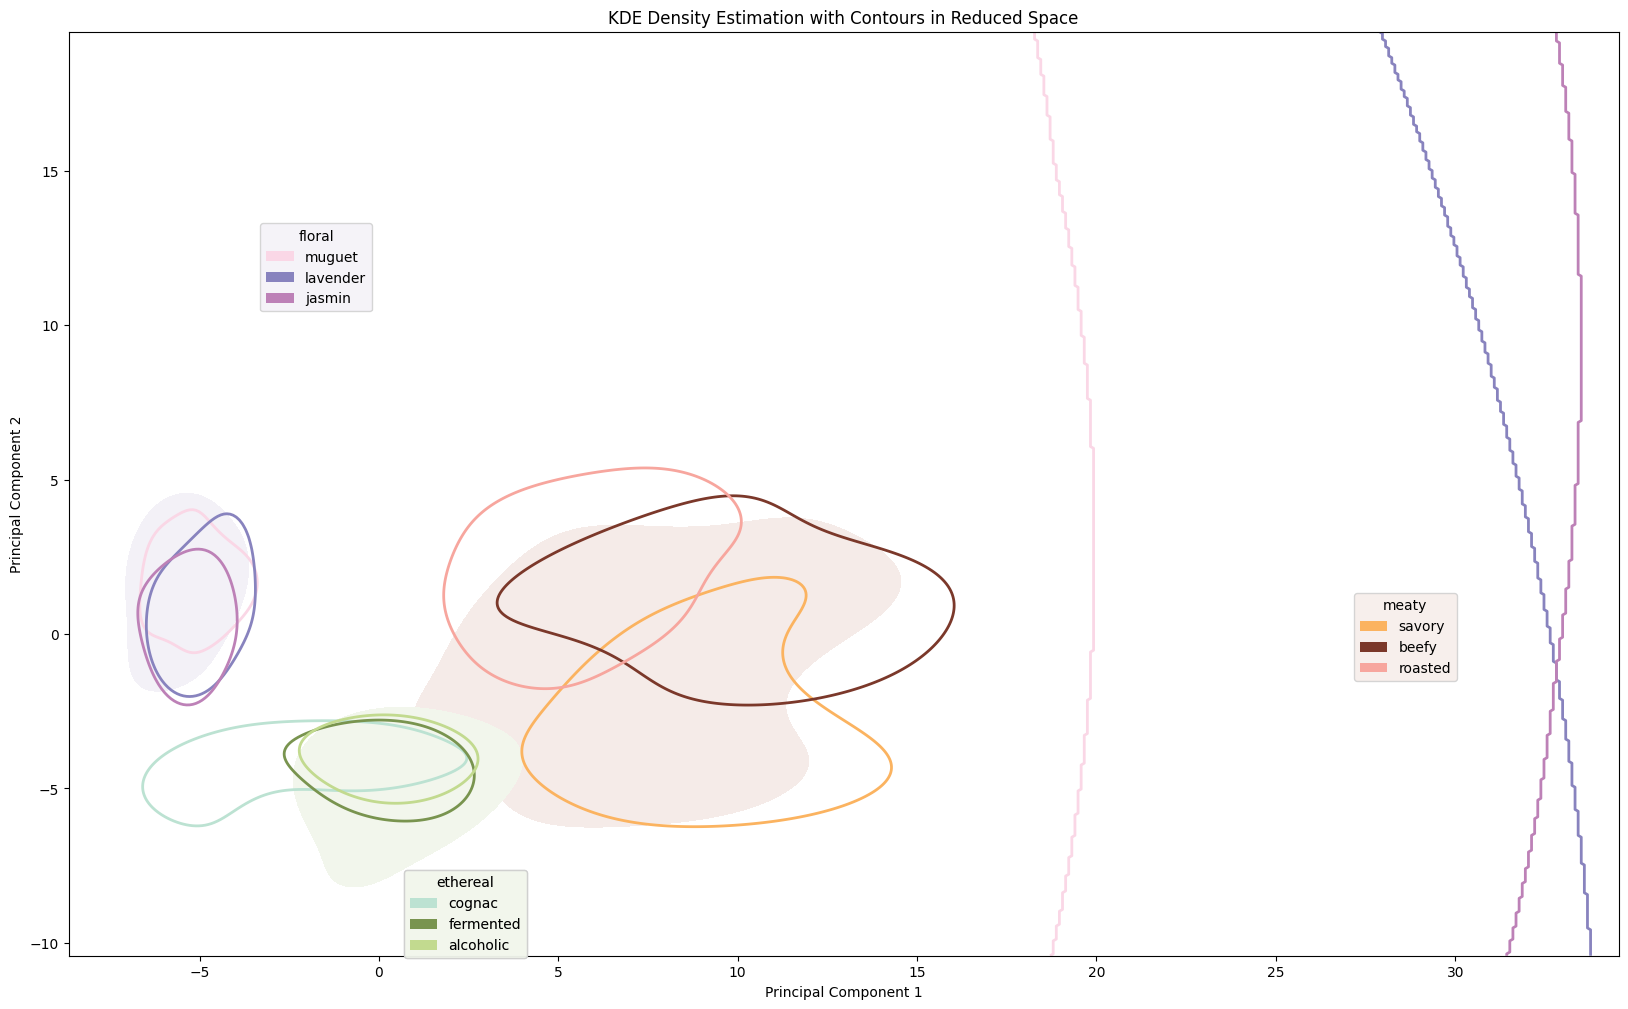

In [11]:
import os
pom_frame(model, dataset, 55)